In [1]:
import sys
sys.path.append('..')
sys.path.append('src')

In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [1]:
# Load and examine the first few lines of each file to understand their structure
bm25_output_file = 'out/facebook_react/bm25/debug_10k/output.teOut'
bert_output_file = 'out/facebook_react/bert_reranker/eval_bm25_fix_combined_bert_maxp/gold/output.teOut'

In [73]:

# Function to read and print the first few lines of a file
def preview_file(file_path, num_lines=5):
    with open(file_path, 'r') as file:
        lines = [next(file) for _ in range(num_lines)]
    return lines

# Preview both files
bert_preview = preview_file(bert_output_file)
bm25_preview = preview_file(bm25_output_file)

bert_preview, bm25_preview

(['f74c89b145c3ed48b0e6e6185c915b96c7f161dc\t{"MAP": 0.0066, "P@1": 0.0, "P@10": 0.0, "P@20": 0.0, "P@30": 0.0, "MRR": 0.0014, "R@1": 0.0, "R@10": 0.0, "R@100": 0.0, "R@1000": 0.6429}\n',
  'cfd8c1bd43fc4fcf708a584924f27a6c79803eae\t{"MAP": 0.6331, "P@1": 1.0, "P@10": 0.6, "P@20": 0.4, "P@30": 0.3, "MRR": 1.0, "R@1": 0.0769, "R@10": 0.4615, "R@100": 0.7692, "R@1000": 0.9231}\n',
  'efd8f6442d1aa7c4566fe812cba03e7e83aaccc3\t{"MAP": 0.2542, "P@1": 1.0, "P@10": 0.2, "P@20": 0.15, "P@30": 0.1, "MRR": 1.0, "R@1": 0.0625, "R@10": 0.125, "R@100": 0.6875, "R@1000": 0.6875}\n',
  '3cc8a9347bd540ac68acfb181fbc7fba7c371648\t{"MAP": 0.0667, "P@1": 0.0, "P@10": 0.0, "P@20": 0.05, "P@30": 0.0333, "MRR": 0.0667, "R@1": 0.0, "R@10": 0.0, "R@100": 1.0, "R@1000": 1.0}\n',
  '31518135c25aaa1b5c2799d2a18b6b9e9178409c\t{"MAP": 0.3333, "P@1": 0.0, "P@10": 0.1, "P@20": 0.05, "P@30": 0.0333, "MRR": 0.3333, "R@1": 0.0, "R@10": 1.0, "R@100": 1.0, "R@1000": 1.0}\n'],
 ['f74c89b145c3ed48b0e6e6185c915b96c7f161dc\t

In [4]:
# Function to load data from a file into a DataFrame
def load_data(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            query_id, metrics_json = line.split('\t')
            metrics = json.loads(metrics_json)
            data.append([query_id] + list(metrics.values()))
    columns = ['Query ID'] + list(json.loads(metrics_json).keys())
    return pd.DataFrame(data, columns=columns)

In [5]:
# Adjusting the load_data function to more robustly handle file reading
def load_data_adjusted(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split('\t')
            if len(parts) == 2:
                query_id, metrics_json = parts
                try:
                    metrics = json.loads(metrics_json)
                    data.append([query_id] + list(metrics.values()))
                except json.JSONDecodeError:
                    continue  # Skip lines with JSON decode errors
            else:
                continue  # Skip lines that do not have the expected format
    columns = ['Query ID'] + list(json.loads(metrics_json).keys())
    return pd.DataFrame(data, columns=columns)

In [ ]:

# Reload BERT and BM25 data into DataFrames with the adjusted function
bert_df_adjusted = load_data_adjusted(bert_output_file)
bm25_df_adjusted = load_data_adjusted(bm25_output_file)

# Merge the two adjusted DataFrames on Query ID for comparison
merged_df_adjusted = pd.merge(bert_df_adjusted, bm25_df_adjusted, on='Query ID', suffixes=('_BERT', '_BM25'))

# Recalculate the improvement of BERT over BM25 for each metric
for metric in merged_df_adjusted.columns[1:]:
    if '_BERT' in metric:
        metric_base = metric.replace('_BERT', '')
        merged_df_adjusted[f'{metric_base}_Improvement'] = merged_df_adjusted[metric] - merged_df_adjusted[f'{metric_base}_BM25']

# Preview the adjusted DataFrame with improvements
merged_df_adjusted.head()

In [6]:
# print(merged_df_adjusted[merged_df_adjusted['Query ID'] == 'cc93a8533264618b7a8e3d6fb56df917214c19d7'])

In [77]:

# Filter out only improvement columns for plotting
improvement_columns = [col for col in merged_df_adjusted.columns if 'Improvement' in col]

# # Plotting
# fig, axes = plt.subplots(len(improvement_columns), 1, figsize=(10, 20))
# fig.tight_layout(pad=5.0)

# for i, metric in enumerate(improvement_columns):
#     axes[i].plot(merged_df_adjusted['Query ID'], merged_df_adjusted[metric], label=f'{metric}', marker='o', linestyle='-', markersize=4)
#     axes[i].set_title(f'Improvement of BERT over BM25 for {metric}')
#     axes[i].set_xlabel('Query ID')
#     axes[i].set_ylabel('Improvement')
#     axes[i].tick_params(axis='x', labelsize=8, rotation=90)
#     axes[i].legend()

# plt.show()

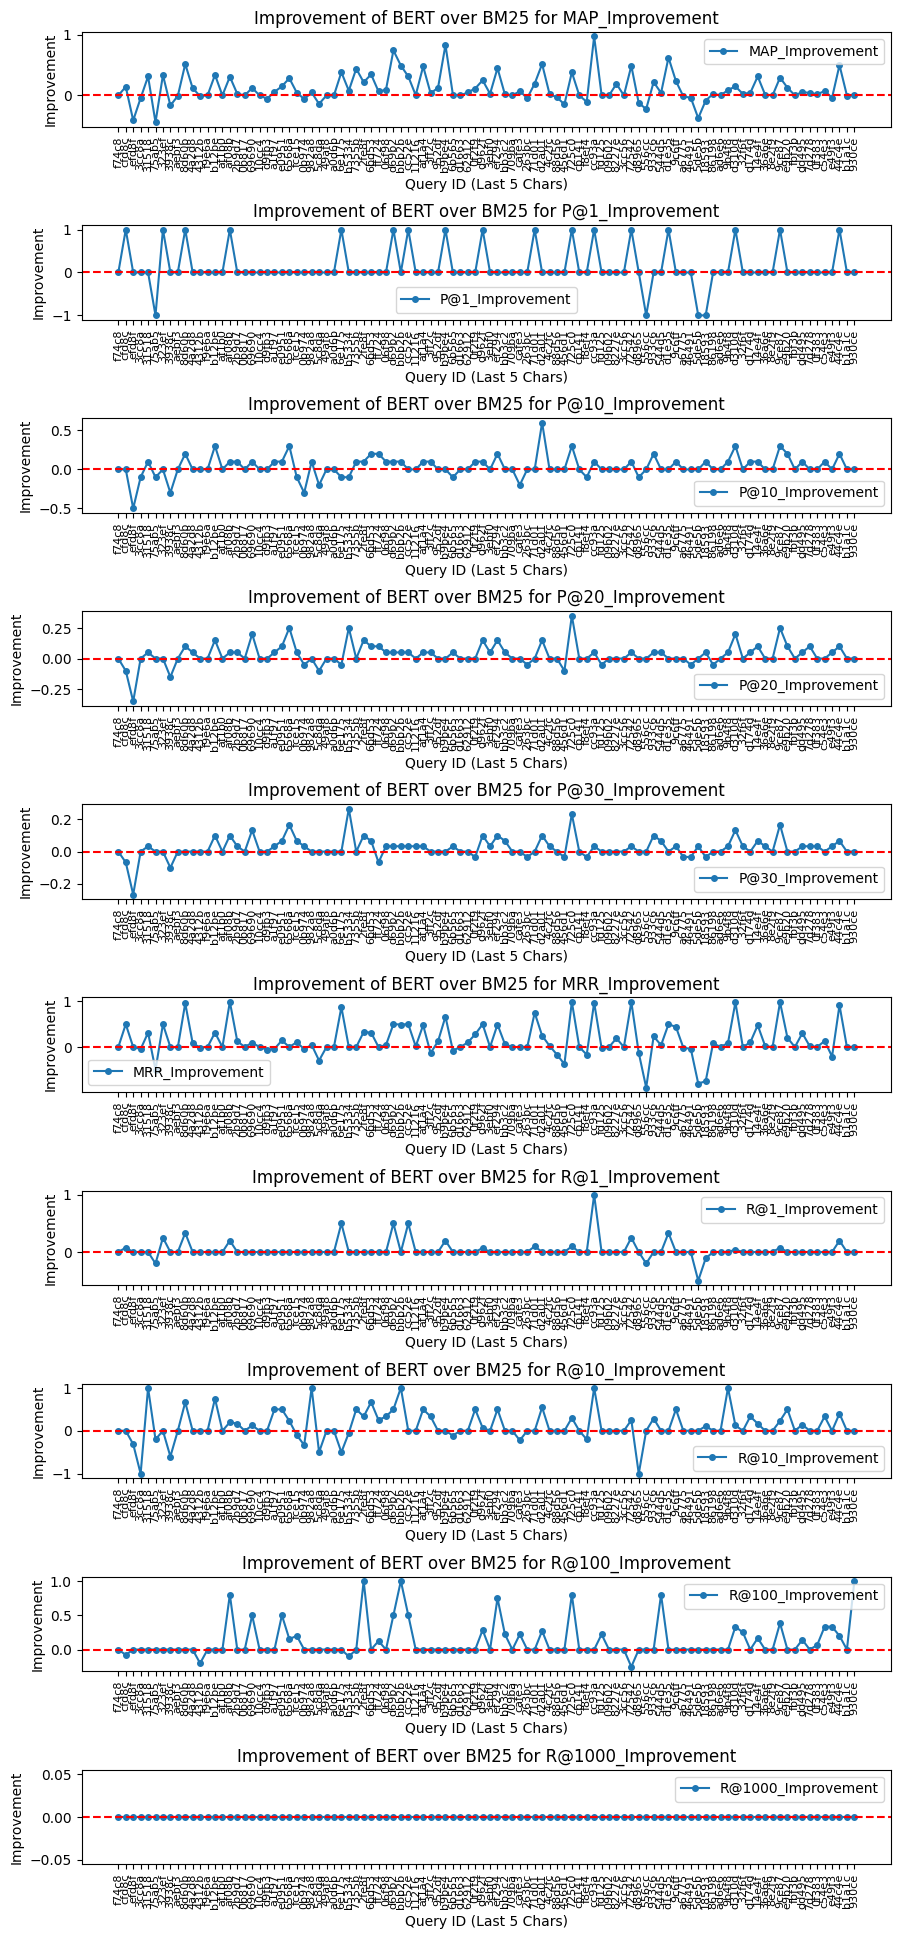

In [78]:
# Plotting with only the last 5 characters of Query ID on the x-axis
fig, axes = plt.subplots(len(improvement_columns), 1, figsize=(10, 20))
fig.tight_layout(pad=5.0)

# Update Query ID in the DataFrame for plotting
merged_df_adjusted['Query ID Short'] = merged_df_adjusted['Query ID'].apply(lambda x: x[:5])

for i, metric in enumerate(improvement_columns):
    axes[i].plot(merged_df_adjusted['Query ID Short'], merged_df_adjusted[metric], label=f'{metric}', marker='o', linestyle='-', markersize=4)
    axes[i].set_title(f'Improvement of BERT over BM25 for {metric}')
    axes[i].set_xlabel('Query ID (Last 5 Chars)')
    axes[i].set_ylabel('Improvement')
    axes[i].tick_params(axis='x', labelsize=8, rotation=90)
    axes[i].legend()

# draw a red horizontal line at y=0
for ax in axes:
    ax.axhline(y=0, color='r', linestyle='--')

plt.show()

In [89]:
from scipy import stats

# Calculate mean, median, and mode of the improvements (absolute and %)

# For storing results
results = {}

for metric in improvement_columns:
    # Absolute values
    mean_abs = merged_df_adjusted[metric].mean()
    median_abs = merged_df_adjusted[metric].median()
    # mode_abs = stats.mode(merged_df_adjusted[metric])[0]# [0]

    # Percentage values - calculated based on BM25 values to give context
    metric_base = metric.replace('_Improvement', '')
    percentage_improvement = (merged_df_adjusted[metric] / merged_df_adjusted[f'{metric_base}_BM25'].replace({0:1}))*100
    mean_pct = percentage_improvement.mean()
    median_pct = percentage_improvement.median()
    # mode_pct = stats.mode(percentage_improvement)[0] #[0]

    results[metric] = {
        'Mean (Absolute)': mean_abs,
        'Median (Absolute)': median_abs,
        # 'Mode (Absolute)': mode_abs,
        'Mean (%)': mean_pct,
        'Median (%)': median_pct,
        # 'Mode (%)': mode_pct
    }

results_df = pd.DataFrame(results).transpose()
print('BERT vs. BM25 Improvement Metrics')
results_df

BERT vs. BM25 Improvement Metrics


,Mean (Absolute),Median (Absolute),Mean (%),Median (%)
MAP_Improvement,0.115185,0.04015,436.349733,54.95797
P@1_Improvement,0.130000,0.00000,13.000000,0.00000
P@10_Improvement,0.037000,0.00000,7.485714,0.00000
P@20_Improvement,0.031500,0.00000,14.933333,0.00000
P@30_Improvement,0.023334,0.00000,17.251906,0.00000
MRR_Improvement,0.148727,0.01580,894.472344,33.32000
R@1_Improvement,0.037224,0.00000,0.733500,0.00000
R@10_Improvement,0.117225,0.00000,16.855659,0.00000
R@100_Improvement,0.114379,0.00000,34.140118,0.00000
R@1000_Improvement,0.000000,0.00000,0.000000,0.00000


In [13]:
def magic(bm25_output_file, bert_output_file, r1, r2):
    # Reload BERT and BM25 data into DataFrames with the adjusted function
    bert_df_adjusted = load_data_adjusted(bert_output_file)
    bm25_df_adjusted = load_data_adjusted(bm25_output_file)

    # Merge the two adjusted DataFrames on Query ID for comparison
    merged_df_adjusted = pd.merge(bert_df_adjusted, bm25_df_adjusted, on='Query ID', suffixes=(f'_{r2}', f'_{r1}'))

    # Recalculate the improvement of BERT over BM25 for each metric
    for metric in merged_df_adjusted.columns[1:]:
        if f'_{r2}' in metric:
            metric_base = metric.replace(f'_{r2}', '')
            merged_df_adjusted[f'{metric_base}_Improvement'] = merged_df_adjusted[metric] - merged_df_adjusted[f'{metric_base}_{r1}']
    improvement_columns = [col for col in merged_df_adjusted.columns if 'Improvement' in col]
    # Plotting with only the last 5 characters of Query ID on the x-axis
    fig, axes = plt.subplots(len(improvement_columns), 1, figsize=(10, 20))
    fig.tight_layout(pad=5.0)

    # Update Query ID in the DataFrame for plotting
    merged_df_adjusted['Query ID Short'] = merged_df_adjusted['Query ID'].apply(lambda x: x[:5])

    for i, metric in enumerate(improvement_columns):
        axes[i].plot(merged_df_adjusted['Query ID Short'], merged_df_adjusted[metric], label=f'{metric}', marker='o', linestyle='-', markersize=4)
        axes[i].set_title(f'Improvement of {r2} over {r1} for {metric}')
        axes[i].set_xlabel('Query ID (Last 5 Chars)')
        axes[i].set_ylabel('Improvement')
        axes[i].tick_params(axis='x', labelsize=8, rotation=90)
        axes[i].legend()

    # draw a red horizontal line at y=0
    for ax in axes:
        ax.axhline(y=0, color='r', linestyle='--')

    plt.show()
    # For storing results
    results = {}

    for metric in improvement_columns:
        # Absolute values
        mean_abs = merged_df_adjusted[metric].mean()
        median_abs = merged_df_adjusted[metric].median()
        # mode_abs = stats.mode(merged_df_adjusted[metric])[0]# [0]

        # Percentage values - calculated based on BM25 values to give context
        metric_base = metric.replace('_Improvement', '')
        percentage_improvement = (merged_df_adjusted[metric] / merged_df_adjusted[f'{metric_base}_{r1}'].replace({0:1}))*100
        mean_pct = percentage_improvement.mean()
        median_pct = percentage_improvement.median()
        # mode_pct = stats.mode(percentage_improvement)[0] #[0]

        results[metric] = {
            'Mean (Absolute)': mean_abs,
            'Median (Absolute)': median_abs,
            # 'Mode (Absolute)': mode_abs,
            'Mean (%)': mean_pct,
            'Median (%)': median_pct,
            # 'Mode (%)': mode_pct
        }

    results_df = pd.DataFrame(results).transpose()
    print(f'{r1} vs. {r2} Improvement Metrics')
    return results_df

# magic(bm25_output_file, bert_output_file)

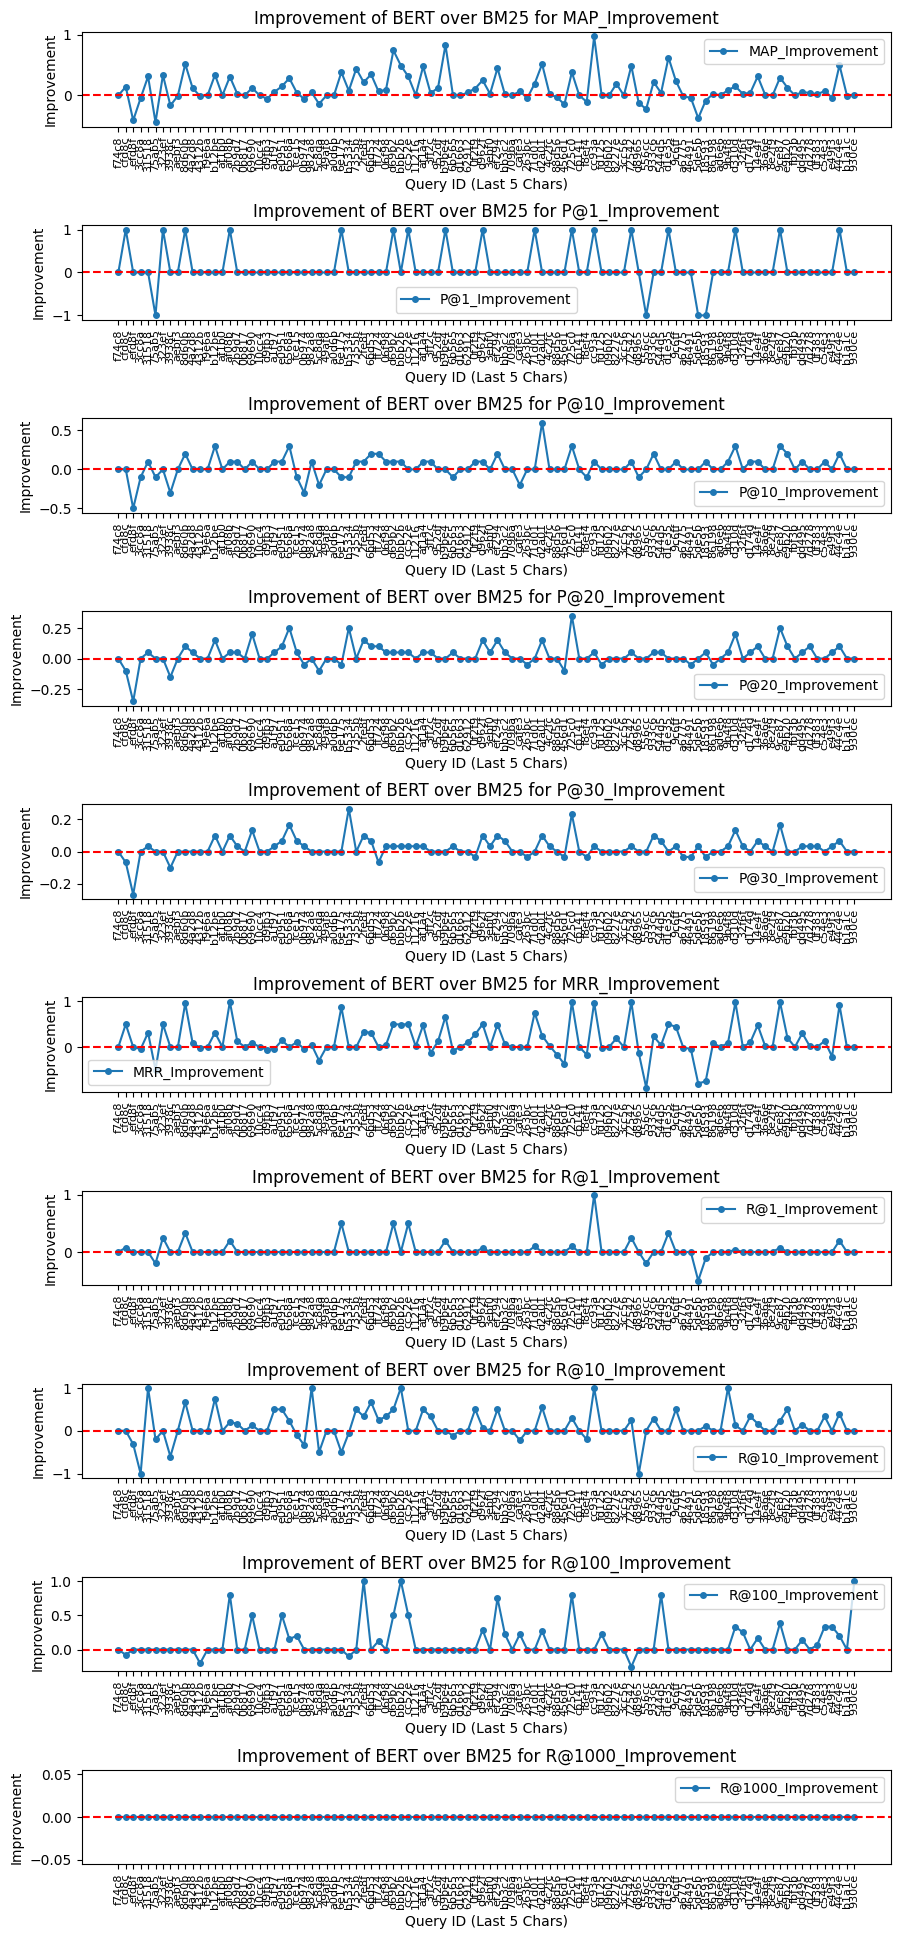

BM25 vs. BERT Improvement Metrics


,Mean (Absolute),Median (Absolute),Mean (%),Median (%)
MAP_Improvement,0.115185,0.04015,436.349733,54.95797
P@1_Improvement,0.130000,0.00000,13.000000,0.00000
P@10_Improvement,0.037000,0.00000,7.485714,0.00000
P@20_Improvement,0.031500,0.00000,14.933333,0.00000
P@30_Improvement,0.023334,0.00000,17.251906,0.00000
MRR_Improvement,0.148727,0.01580,894.472344,33.32000
R@1_Improvement,0.037224,0.00000,0.733500,0.00000
R@10_Improvement,0.117225,0.00000,16.855659,0.00000
R@100_Improvement,0.114379,0.00000,34.140118,0.00000
R@1000_Improvement,0.000000,0.00000,0.000000,0.00000


In [10]:
magic(bm25_output_file, bert_output_file, r1='BM25', r2='BERT')

In [11]:
code_bert_output = 'out/facebook_react/code_reranker_file/eval_bm25_fix/gold/output.teOut'

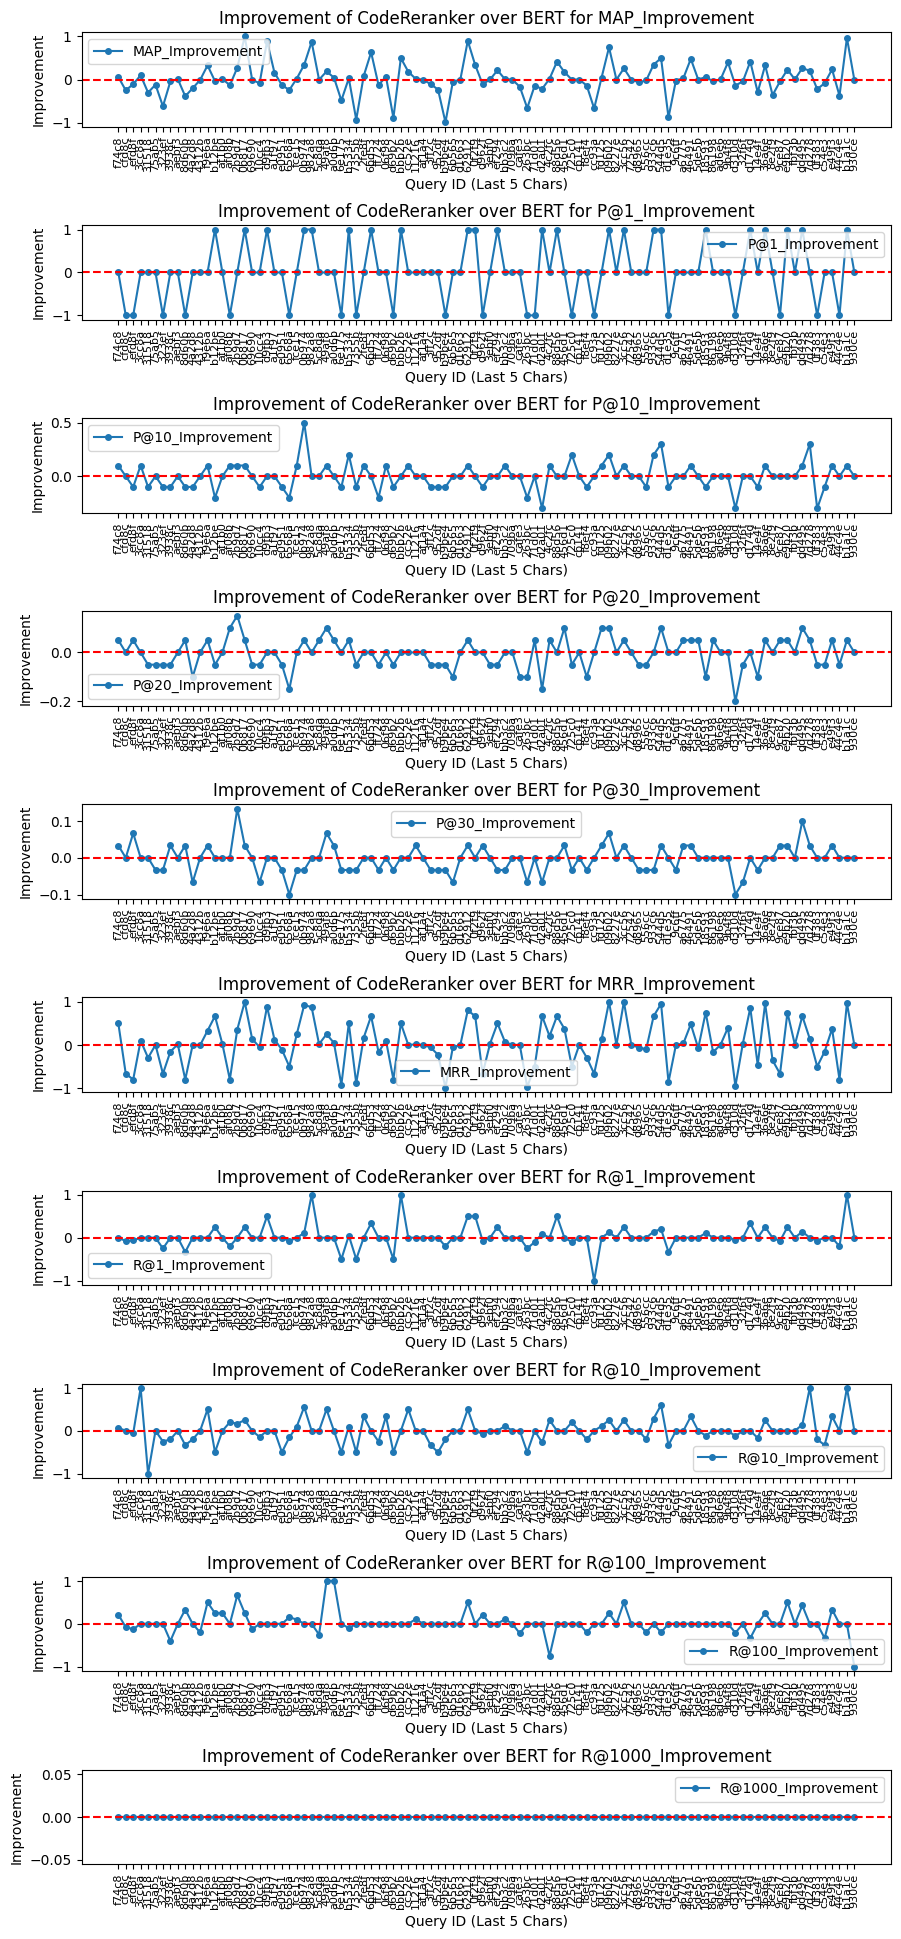

BERT vs. CodeReranker Improvement Metrics


,Mean (Absolute),Median (Absolute),Mean (%),Median (%)
MAP_Improvement,0.024386,0.00035,1772.585148,0.813422
P@1_Improvement,0.030000,0.00000,3.000000,0.000000
P@10_Improvement,0.002000,0.00000,-6.750000,0.000000
P@20_Improvement,-0.003500,0.00000,-3.793651,0.000000
P@30_Improvement,-0.002669,0.00000,-0.427921,0.000000
MRR_Improvement,0.048991,0.00535,3101.948150,37.167325
R@1_Improvement,0.032009,0.00000,-11.859500,0.000000
R@10_Improvement,0.015880,0.00000,-2.218369,0.000000
R@100_Improvement,0.031921,0.00000,9.162469,0.000000
R@1000_Improvement,0.000000,0.00000,0.000000,0.000000


In [12]:
magic(bert_output_file, code_bert_output, r1='BERT', r2='CodeReranker')

In [5]:
before_pd = pd.DataFrame(before_all)
after_pd = pd.DataFrame(after_all)

In [9]:
# Code to calculate the average of all metrics in a list of dictionaries called metrics
def calculate_averages(metrics):
    # Initialize a dictionary to hold the sum of each metric
    sums = {}
    # Loop through each metric in each dictionary to sum them up
    for metric in metrics:
        for key, value in metric.items():
            if key in sums:
                sums[key] += value
            else:
                sums[key] = value
    # Calculate the average for each metric
    averages = {key: value / len(metrics) for key, value in sums.items()}
    return averages

# Example usage:
# averages = calculate_averages(metrics)
# print(averages)

In [19]:
before_oracle = calculate_averages(metrics)
after_oracle = {'MAP': 0.3744, 'P@1': 0.39, 'P@10': 0.301, 'P@20': 0.2115, 'P@30': 0.1593, 'MRR': 0.5554, 'R@1': 0.1288, 'R@10': 0.4846, 'R@100': 0.9004, 'R@1000': 0.9004}

In [12]:
# print absolute and % difference
# for key, value in before_oracle.items():
    # print(key, "absolute difference:", after_oracle[key] - value, "percentage difference:", (after_oracle[key] - value) / value * 100)

# print absolute and % difference by making into a df (columns are before, after, absolute difference, % difference)

oracle_df = pd.DataFrame([calculate_averages(before_all), calculate_averages(after_all)]).T
oracle_df.columns = ['Before Oracle', 'After Oracle']
oracle_df['Absolute Difference'] = oracle_df['After Oracle'] - oracle_df['Before Oracle']
oracle_df['% Difference'] = oracle_df['Absolute Difference'] / oracle_df['Before Oracle'] * 100
oracle_df

,Before Oracle,After Oracle,Absolute Difference,% Difference
MAP,0.085076,0.332275,0.247199,290.562556
P@1,0.080000,0.390000,0.310000,387.500000
P@10,0.058000,0.233000,0.175000,301.724138
P@20,0.056000,0.156000,0.100000,178.571429
P@30,0.052662,0.113997,0.061335,116.469181
MRR,0.177948,0.554369,0.376421,211.534268
R@1,0.011178,0.128763,0.117585,1051.932367
R@10,0.121057,0.493152,0.372095,307.371734
R@100,0.900390,0.900390,0.000000,0.000000
R@1000,0.900390,0.900390,0.000000,0.000000


In [ ]:
before_oracle_code_output = ''
after_oracle_code_output = ''

In [49]:
# Non Oracle
# BM25
{"MAP": 0.1372, "P@1": 0.1, "P@10": 0.09, "P@20": 0.0635, "P@30": 0.0503, "MRR": 0.2159, "R@1": 0.0208, "R@10": 0.2025, "R@100": 0.4955, "R@1000": 0.7863}

# BERT Reranker
{"MAP": 0.2524, "P@1": 0.23, "P@10": 0.127, "P@20": 0.095, "P@30": 0.0737, "MRR": 0.3647, "R@1": 0.058, "R@10": 0.3197, "R@100": 0.6099, "R@1000": 0.7863}

# BERT Reranker @ 1000 + Code Reranker @ 100
{"MAP": 0.2768, "P@1": 0.26, "P@10": 0.129, "P@20": 0.0915, "P@30": 0.071, "MRR": 0.4137, "R@1": 0.09, "R@10": 0.3356, "R@100": 0.6418, "R@1000": 0.7863}





# Oracle Before CodeReranker Reranking (BM25 + Adding rest of FIDs randomly in top 100)
{'MAP': 0.1474, 'P@1': 0.16, 'P@10': 0.1379, 'P@20': 0.1129, 'P@30': 0.098, 'MRR': 0.3174, 'R@1': 0.0274, 'R@10': 0.2754, 'R@100': 0.9003, 'R@1000': 0.9003}

# Oracle After CodeReranker Reranking (BM25 + Adding rest of FIDs randomly in top 100)
{'MAP': 0.3744, 'P@1': 0.39, 'P@10': 0.301, 'P@20': 0.2115, 'P@30': 0.1593, 'MRR': 0.5554, 'R@1': 0.1288, 'R@10': 0.4846, 'R@100': 0.9004, 'R@1000': 0.9004}

{'MAP': 0.3744,
 'P@1': 0.39,
 'P@10': 0.301,
 'P@20': 0.2115,
 'P@30': 0.1593,
 'MRR': 0.5554,
 'R@1': 0.1288,
 'R@10': 0.4846,
 'R@100': 0.9004,
 'R@1000': 0.9004}

In [24]:
# load fid_to_path and path_to_fid json files to dicts
with open(f"facebook_react_FID_to_paths.json") as f:
    fid_to_path = json.load(f)

# make all fids ints
fid_to_path = {int(k): v for k, v in fid_to_path.items()}

with open(f"facebook_react_path_to_FID.json") as f:
    path_to_fid = json.load(f)

In [28]:
fid_to_path[3219]

['packages/react-reconciler/src/ReactFiberBeginWork.js',
 'packages/react-reconciler/src/ReactFiberBeginWork.new.js',
 'src/renderers/shared/fiber/ReactFiberBeginWork.js',
 'packages/react-reconciler/src/ReactFiberBeginWork.old.js']

In [29]:
path_to_fid['src/backend/renderer.js']

1382

In [30]:
fid_to_path[1382]

['extension/src/backend/renderer.js',
 'src/backend/renderer.js',
 'packages/react-devtools-shared/src/backend/renderer.js']

In [31]:
# find the fid with the most number of paths

max_fid = max(fid_to_path, key=lambda k: len(fid_to_path[k]))
max_fid

1184

In [48]:
# from utils import run_command
# REPO_DIR = '/home/ssg2/ssg2/ds/repos/facebook_react'

# def get_file_path_at_commit(repo_path, commit_id, fid):
#     possible_paths = fid_to_path[fid]
#     for path in possible_paths:
#         _, status_code = run_command(f'cd {repo_path} && git cat-file -e {commit_id}:{path}', return_status=True)
#         if status_code == 0:
#             return path
#     print(f'WARNING: Could not find file path at commit {commit_id} for FID {fid} for {REPO_DIR}')
#     return 'NA'